# Reconocimiento de Patrones
[Curso de Reconocimiento de Patrones]

Departamento Electrónica

Universidad Popular del Cesar

José Ramón Iglesias

---

# Ejemplos: Soluciones Generales en Selección de Características

En este ejemplo se muestra distintas estrategias e implementaciones para la selección de características




# Setup inicial

Liberías necesarias para que funcione el algoritmo.

## Instalación de PyBalu

En los ejemplos de este notebook, se utiliza esta librería sólo para la extracción de características geométricas.

In [ ]:
# Instalación de PyBalu

!pip install scipy==1.2
!pip3 install pybalu==0.2.5

print('PyBalu library installed.')


## Setup de librerías

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from   sklearn.metrics import confusion_matrix, accuracy_score
from   seaborn import heatmap
from   tqdm.auto import tqdm
from   sklearn.neighbors import KNeighborsClassifier
from   pybalu.feature_selection import clean
from   pybalu.feature_transformation import normalize
from   IPython.display import clear_output


## Carga de base de datos

En este ejemplo, usaremos las características ya extraidas en el ejemplo que realiza el reconocimiento de los caracteres A,B,X,Y,Z con diversos tamaños y diversas orientaciones. Para la solución se utiliza los descriptores ya que son invariantes a la rotación y a la escala. [Ver más...](https://colab.research.google.com/drive/14bwzAfN3QVSPGNKjLvrhr7zl02SkRu08?usp=sharing)


La base de datos consiste en 5 clases y 100 imágenes por clase

In [ ]:
!wget https://www.dropbox.com/s/y71lwhzppw3woe4/Features_Letras.zip?dl=0
!unzip Features_Letras

--2021-05-06 15:28:52--  https://www.dropbox.com/s/knq4187tuj2vwsn/Features_Letras.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/knq4187tuj2vwsn/Features_Letras.zip [following]
--2021-05-06 15:28:52--  https://www.dropbox.com/s/raw/knq4187tuj2vwsn/Features_Letras.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc483fca307492ae4a7cfde5482b.dl.dropboxusercontent.com/cd/0/inline/BN-ukLfmpdfW16gsTnpj9ELvAXuKg4J3I_0XFB7JrrIizQNx0gwK2R_gZZ4n00eyvteu7dC6XIHfQNfAPrxYFaLPX1uIek7DSuSVzboxOTPQ5g93KcFRGY7r6HKYCP6siijcjNBKJUFc922uTXelpsT0/file# [following]
--2021-05-06 15:28:52--  https://uc483fca307492ae4a7cfde5482b.dl.dropboxusercontent.com/cd/0/inline/BN-ukLfmpdfW16gsTnpj9ELvAXuKg4J3I_0XFB7JrrIizQNx0gwK2R_gZZ4n00eyvteu7

## Funciones necesarias

In [ ]:
def load_features(prefix):
    X = np.load(prefix+'_X.npy')            # features
    y = np.load(prefix+'_y.npy')            # labels
    print('Features: '+str(X.shape[0]) +' samples with '+str(X.shape[1]) +' features')
    print(' Classes: '+str(int(np.min(y)))+'...'+str(int(np.max(y))))
    return X,y

# Separación entre training y testing
def SplitTrainTest(X,y,n):

  K      = np.int(np.max(y)+1)      # número de clases
  N      = np.int(X.shape[0]/K)     # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1
  
  return Xtrain,ytrain,Xtest,ytest


# Clasificación usando KNN con n_vecinos
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_vecinos=1,echo ='on'):
  knn = KNeighborsClassifier(n_neighbors=n_vecinos)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C = confusion_matrix(ytest,ypred)



  if echo == 'on':
    print('Entrenando con '+str(Xtrain.shape[0])+' muestras y probando con '+str(Xtest.shape[0])+' muestras')
    print('Los datos tienen '+str(Xtrain.shape[1])+' features')

    acc_st = "{:.2f}".format(acc*100)

    print('Testing Accuracy = '+acc_st+'%')
    print()
    #print('Matriz de Confusión:')
    #print(C)
    heatmap(C, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()
  return acc,C


# Normalización MinMax: cada columna es normalizada para que tenga minimo 0 y máximo 1
def minmax(X):
    ma = X.max(0)
    mi = X.min(0)
    md    = ma-mi    
    a     = 1/ md
    b     = -mi/md
    return X * a + b, a, b


# Pasos iniciales (sin selección)

Features: 500 samples with 45 features
 Classes: 0...4

Evaluación con datos Originales:
Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 45 features
Testing Accuracy = 70.40%



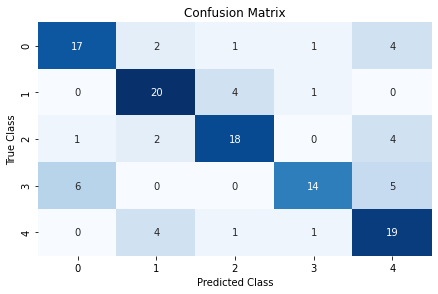


Cleaning:
Seleccionadas 41/45 features: [ 0  1  2  3  4  5  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44]

Evaluación con datos después de  Clean y Normalización:
Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 41 features
Testing Accuracy = 79.20%



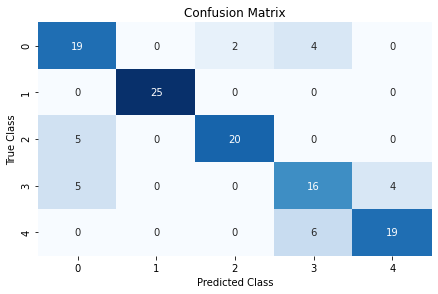

In [ ]:
# 1. Caracteristicas
X,y = load_features('Letras')

# 2. Definicion Training/Testing
ntrain = 75
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)

# Clasificacion con datos originales
print()
print('Evaluación con datos Originales:')
print('================================')

acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

# 3. Cleaning
sclean = clean(Xtrain)            # índice de características seleccionadas
Xtrain_clean = Xtrain[:,sclean]   # nuevo training
Xtest_clean  = Xtest[:,sclean]    # nuevo testing
print()
print('Cleaning:')
print('=========')
print('Seleccionadas '+str(len(sclean))+'/'+str(X.shape[1])+' features: '+str(sclean))

# 4. Normalización MinMax
Xtrain_norm, a, b = minmax(Xtrain_clean)
Xtest_norm        = Xtest_clean * a + b

# Clasificacion con datos normalizados
print()
print('Evaluación con datos después de  Clean y Normalización:')
print('=======================================================')
acc,C = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest,1)



# Selección de Características

## SFS (Librería PyBalu)

In [ ]:
from   pybalu.feature_selection import sfs

# 5. Selección con SFS - Fisher
sel = sfs(Xtrain_norm,ytrain,8,show=True)
Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

# 6, 7, 8. Clasificación con caracteristicas seleccionadas
print()
print('Datos con SFS:')
print('==============')
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)



## Búsqueda Exhaustiva (Librería PyBalu)

In [ ]:
from   pybalu.feature_selection import exsearch

# 5. Selección con Búsqueda Exhaustiva - Fisher

# Primero hacemos una preselección para reducir el espacio de búsqueda
sel_1 = sfs(Xtrain_norm,ytrain,16,show=True)
Xtrain_sel_1 = Xtrain_norm[:,sel_1]
Xtest_sel_1  = Xtest_norm[:,sel_1]

# Luego hacemos búsqueda exhaustiva
sel_2 = exsearch(Xtrain_sel,ytrain,6,show=True)
Xtrain_sel_2 = Xtrain_sel_1[:,sel_2]
Xtest_sel_2  = Xtest_sel_1[:,sel_2]


# 6, 7, 8. Clasificación con caracteristicas seleccionadas
print()
print('Datos con SFS + Búsqueda Exhaustiva:')
print('====================================')
acc,C = ClassifierKNN(Xtrain_sel_2,ytrain,Xtest_sel_2,ytest,1)


## RFECV (Librería sklearn)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

estimator = SVC(kernel="linear")


selector  = RFECV(estimator, step=1,cv=5)
selector  = selector.fit(Xtrain_norm, ytrain)
sel       = np.nonzero(selector.support_)[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


## RFE (Librería sklearn)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel="linear")

p = 8
selector  = RFE(estimator, p, step=1)
selector  = selector.fit(Xtrain_norm, ytrain)
sel       = np.nonzero(selector.support_)[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


## SFS (Librería mlxtend)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs

estimator = KNeighborsClassifier(n_neighbors=5)
p = 12
forward = True
sfs = mlxsfs(estimator, k_features=p,forward=forward,floating=False,verbose=2,scoring='accuracy',cv=10)

sfs = sfs.fit(Xtrain_norm, ytrain)
sel = list(sfs.k_feature_idx_)

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


## SBS (Librería mlxtend)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    2.0s finished

[2021-05-06 15:51:47] Features: 40/12 -- score: 0.9702702702702704[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.8s finished

[2021-05-06 15:51:49] Features: 39/12 -- score: 0.972972972972973[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.7s finished

[2021-05-06 15:51:50] Features: 38/12 -- score: 0.9756756756756756[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 12 features
Testing Accuracy = 91.20%



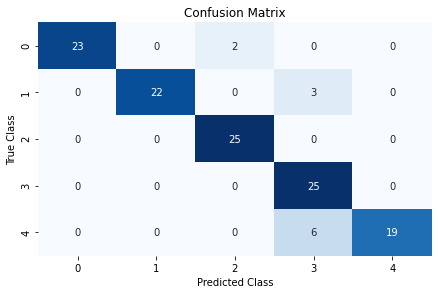

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as mlxsfs

estimator = KNeighborsClassifier(n_neighbors=5)
p = 12
forward = False
sfs = mlxsfs(estimator, k_features=p,forward=forward,floating=False,verbose=2,scoring='accuracy',cv=10)

sfs = sfs.fit(Xtrain_norm, ytrain)
sel = list(sfs.k_feature_idx_)

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]
acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


## SelectKBest (Librería sklearn)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

p = 8
model =  SelectKBest(chi2,k=p)

eps = 1e-8
model.fit(Xtrain_norm+eps, ytrain)  

sel        = np.nonzero(model.get_support())[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


## Basados en árboles (Librería sklearn)

In [ ]:

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

p = 10

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

model = SelectFromModel(lgbc, max_features=p)
model.fit(Xtrain_norm, ytrain)

sel        = np.nonzero(model.get_support())[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


In [ ]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

p = 8

model = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=p)
model.fit(Xtrain_norm, ytrain)

sel        = np.nonzero(model.get_support())[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


In [ ]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

p = 10
model = SelectFromModel(LogisticRegression(penalty="l2"), max_features=p)
model.fit(Xtrain_norm, ytrain)

sel        = np.nonzero(model.get_support())[0]

Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

acc,C = ClassifierKNN(Xtrain_sel,ytrain,Xtest_sel,ytest,1)


# Transformación de Características

## PCA (Librería PyBalu)

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 10 features
Testing Accuracy = 89.60%



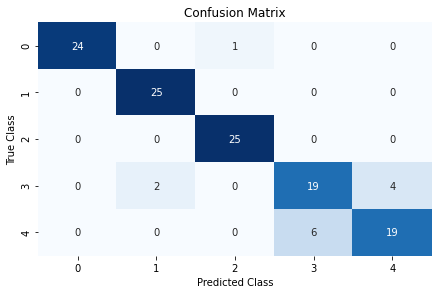

In [ ]:
from   pybalu.feature_selection import sfs
from   pybalu.feature_transformation import pca

# Primero hacemos una preselección para reducir el espacio de búsqueda
sel = sfs(Xtrain_norm,ytrain,20)
Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

# Luego hacemos PCA
Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sel, n_components=10)
Xtest_pca = np.matmul(Xtest_sel - Xm, A) # Paso 5: PCA

acc,C = ClassifierKNN(Xtrain_pca,ytrain,Xtest_pca,ytest,1)

## ICA (Librería sklearn)

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 8 features
Testing Accuracy = 91.20%



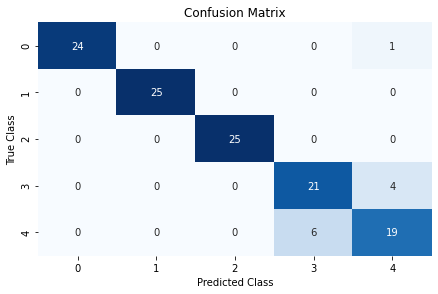

In [ ]:
from pybalu.feature_selection import sfs
from sklearn.decomposition import FastICA

# Primero hacemos una preselección para reducir el espacio de búsqueda
sel = sfs(Xtrain_norm,ytrain,30)
Xtrain_sel = Xtrain_norm[:,sel]
Xtest_sel  = Xtest_norm[:,sel]

# Luego hacemos ICA
ica = FastICA(n_components=8, random_state=0)
ica.fit(Xtrain_sel, ytrain)    

Xtrain_ica = ica.transform(Xtrain_sel)
Xtest_ica  = ica.transform(Xtest_sel)

acc,C = ClassifierKNN(Xtrain_ica,ytrain,Xtest_ica,ytest,1)


## PLSR (Librería sklearn)

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 10 features
Testing Accuracy = 94.40%



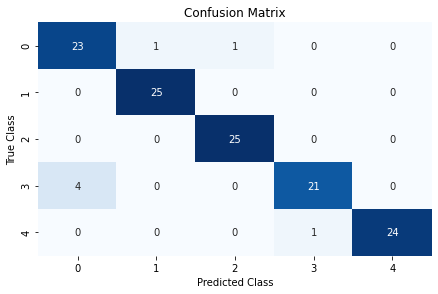

In [ ]:
from sklearn.cross_decomposition import PLSRegression  

plsr = PLSRegression(n_components=10)    

plsr.fit(Xtrain_norm, ytrain)    

Xtrain_plsr = plsr.transform(Xtrain_norm)
Xtest_plsr  = plsr.transform(Xtest_norm)

acc,C = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest,1)




# Transformación y Selección de Características

## PCA y SFS (Librería PyBalu)

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 8 features
Testing Accuracy = 95.20%



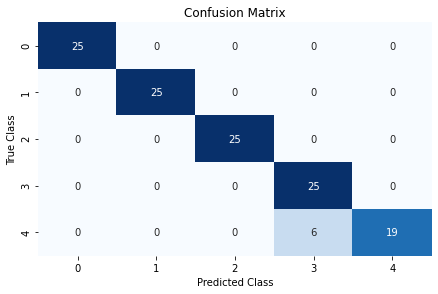

In [ ]:
# Primero hacemos una preselección para escoger buenas características
sel_1 = sfs(Xtrain_norm,ytrain,12)
Xtrain_sel_1 = Xtrain_norm[:,sel_1]
Xtest_sel_1  = Xtest_norm[:,sel_1]

# Luego hacemos PCA
Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sel_1, n_components=4)
Xtest_pca = np.matmul(Xtest_sel_1 - Xm, A) # Paso 5: PCA

# Luego concatenamos y hacemos un nuevo SFS
Xtrain_sfspca = np.concatenate((Xtrain_sel_1,Xtrain_pca),axis=1)
Xtest_sfspca  = np.concatenate((Xtest_sel_1,Xtest_pca),axis=1)

sel_2 = sfs(Xtrain_sfspca,ytrain,8)
Xtrain_sel_2 = Xtrain_sfspca[:,sel_2]
Xtest_sel_2  = Xtest_sfspca[:,sel_2]


acc,C = ClassifierKNN(Xtrain_sel_2,ytrain,Xtest_sel_2,ytest,1)

## ICA y SFS (Librería sklearn)

Entrenando con 375 muestras y probando con 125 muestras
Los datos tienen 8 features
Testing Accuracy = 95.20%



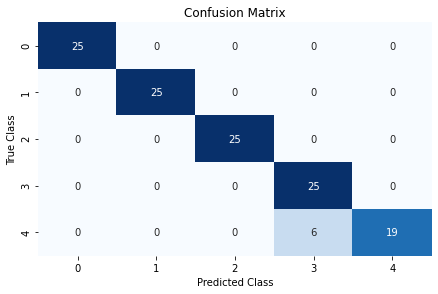

In [ ]:
# Primero hacemos una preselección para escoger buenas características
sel_1 = sfs(Xtrain_norm,ytrain,12)
Xtrain_sel_1 = Xtrain_norm[:,sel_1]
Xtest_sel_1  = Xtest_norm[:,sel_1]

# Luego hacemos ICA
ica = FastICA(n_components=8, random_state=0)
ica.fit(Xtrain_sel, ytrain)    

Xtrain_ica = ica.transform(Xtrain_sel)
Xtest_ica  = ica.transform(Xtest_sel)

# Luego concatenamos y hacemos un nuevo SFS
Xtrain_sfsica = np.concatenate((Xtrain_sel_1,Xtrain_ica),axis=1)
Xtest_sfsica  = np.concatenate((Xtest_sel_1,Xtest_ica),axis=1)

sel_2 = sfs(Xtrain_sfsica,ytrain,8)
Xtrain_sel_2 = Xtrain_sfsica[:,sel_2]
Xtest_sel_2  = Xtest_sfsica[:,sel_2]


acc,C = ClassifierKNN(Xtrain_sel_2,ytrain,Xtest_sel_2,ytest,1)